# Notebook to analyze latent space of UKBioBank, when trained with all subjects of UKBioBank

In [1]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

INFO: you cannot use deep_folding in brainvisa. Probably OK.


/volatile/jc225751/Runs/59_analysis_ukbiobank/Program/2023_agaudin_jchavas_folding_supervised/contrastive/evaluation/train_multiple_classifiers.py:495: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_name='config_no_save', config_path="../configs")


In [2]:
# test model
test_model = "/volatile/jc225751/Runs/59_analysis_ukbiobank/Output/trained_on_all_HCP/chosen_model/chosen_model"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset_train = 'cingulate_UkBioBank_full'

# load the data
train_df = pd.read_csv(test_model+'/'+dataset_train+'_embeddings/train_val_embeddings.csv', index_col=0)
train_df.sort_index(inplace=True)
len(train_df)

21070

In [3]:
dataset_test = 'cingulate_HCP_full_NEOFAC_O'

test_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
test_df.sort_index(inplace=True)


In [4]:
dataset_second = 'cingulate_ACCpatterns'
second_df = pd.read_csv(test_model+'/'+dataset_second+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
second_df.sort_index(inplace=True)


# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset_second+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)
len(prediction_df)

341

In [5]:
dataset_third = 'cingulate_UkBioBank_full'
third_df = pd.read_csv(test_model+'/'+dataset_third+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
third_df.sort_index(inplace=True)

In [6]:
prediction_df.head()

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
1-03HUBJO_t0,1,0.765572,0.785239,0.788553,0.748675,0.744543,0.770777,0.771964,0.781899,0.774496,...,0.758255,0.782227,0.740891,0.761771,0.776692,0.791845,0.780552,0.771982,0.771192,0.797909
1-08ANDTI_t0,1,0.700609,0.715498,0.720873,0.685306,0.680069,0.702716,0.703357,0.713802,0.705850,...,0.693025,0.713286,0.678915,0.693169,0.712618,0.722506,0.713154,0.704784,0.704403,0.729193
1-11LEBJO_t0,1,0.487327,0.477722,0.488950,0.482835,0.475226,0.476916,0.475213,0.483314,0.476545,...,0.481349,0.479680,0.483222,0.468990,0.500000,0.483077,0.485695,0.481942,0.482266,0.489070
1-15LEHMI_t0,0,0.780367,0.800781,0.803645,0.763293,0.759431,0.786153,0.787439,0.797155,0.789950,...,0.773177,0.797647,0.755276,0.777356,0.791191,0.807222,0.795683,0.787325,0.786287,0.813084
1-17COLMA_t0,0,0.395146,0.375654,0.387690,0.396230,0.388531,0.380516,0.378018,0.383690,0.378599,...,0.390748,0.379214,0.399641,0.374581,0.404195,0.379262,0.387107,0.386125,0.386545,0.383821


## Visualize umap

In [7]:
def display_umaps_true_labels(visual_embs_train, reducer, test_df, prediction_df, verbose=False):
    if verbose:
        print("Test df:")
        print(test_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    if verbose:
        print("UMAP embeddings")
        print(visual_embs_train.shape)
        print(visual_embs_train[:5])
    visual_embs_test = reducer.transform(test_df)

    ## plot the graphs

    # plt.figure()
    # plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c='green', alpha=0.4)

    # plot for true labels/volatile/jc225751/Runs/59_analysis_ukbiobank/Output/
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c=colors, s=1, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    plt.show()

    return pd.DataFrame(visual_embs_test, index=test_df.index.values)

In [8]:
def compute_umap(df, n_neighbors=15):
    # apply umap
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [9]:
len(third_df)

21070

# UMAP on HCP

In [32]:
visual_embs, reducer = compute_umap(test_df, n_neighbors=15)

In [33]:
hcp_embs = visual_embs.copy()

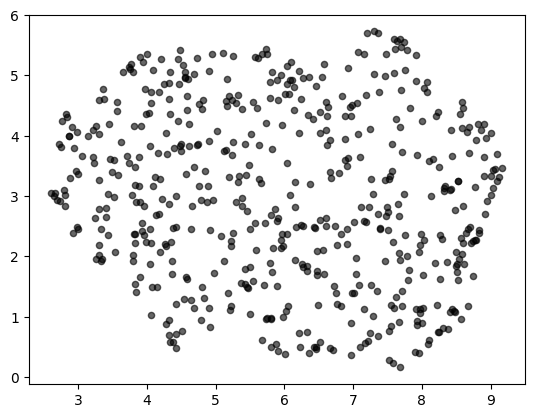

In [39]:
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='black', s=20, alpha=0.6)

In [35]:
second_embs = reducer.transform(second_df)

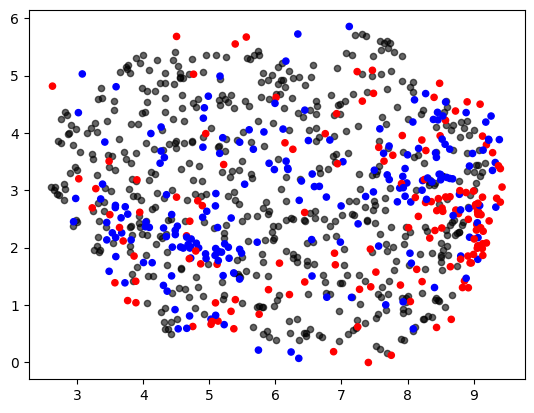

In [36]:
# plot for true labels
cmap = ['b', 'r']
colors = [cmap[i] for i in prediction_df.label]

plt.scatter(visual_embs[:,0], visual_embs[:,1], c='black', s=20, alpha=0.6)
plt.scatter(second_embs[:,0], second_embs[:,1], c=colors, s=20, alpha=1)

In [37]:
third_embs = reducer.transform(third_df)

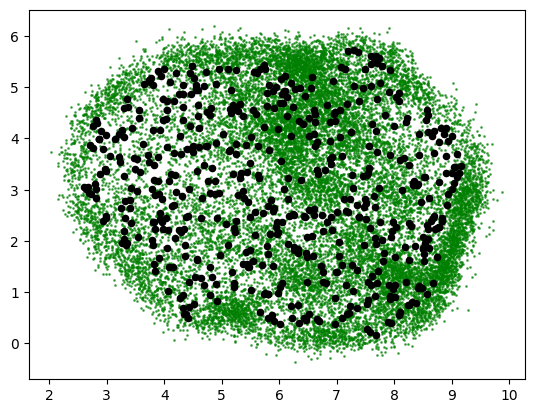

In [38]:
plt.scatter(third_embs[:,0], third_embs[:,1], c='g', s=1, alpha=0.6)
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='black', s=20, alpha=1)


# UMAP on UKBioBank

In [17]:
visual_embs, reducer = compute_umap(third_df, n_neighbors=100)

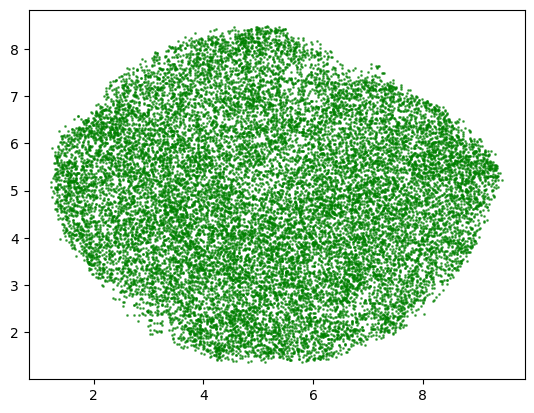

In [18]:
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='g', s=1, alpha=0.6)

In [19]:
second_embs = reducer.transform(second_df)

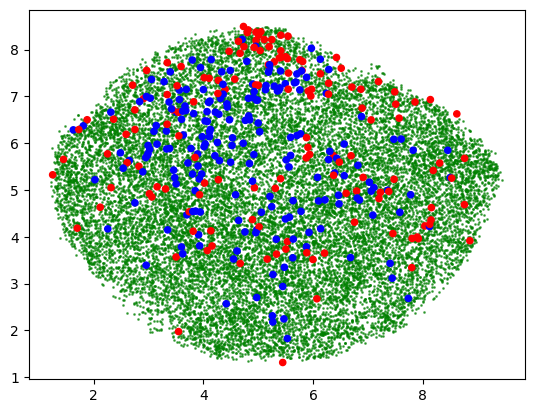

In [20]:
cmap = ['b', 'r']
colors = [cmap[i] for i in prediction_df.label]
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='g', s=1, alpha=0.6)
plt.scatter(second_embs[:,0], second_embs[:,1], c=colors,  s=20, alpha=1)

In [21]:
second_df.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10
ID,,,,,,,,,,
1-03HUBJO_t0,2.430817,-0.753150,3.716913,25.346935,10.668212,-11.689108,-3.995827,9.258430,-14.197102,-12.007984
1-08ANDTI_t0,-8.481001,5.589873,4.987264,34.308014,8.747616,-2.414185,11.343955,0.820971,-6.977499,-5.552534
1-11LEBJO_t0,-8.426315,0.432132,6.490889,33.058620,6.084901,-5.215346,11.091612,-0.571256,-6.770755,-10.114146
1-15LEHMI_t0,-7.307198,-3.465610,-0.070041,30.035913,8.404944,4.027640,-5.209754,-3.883528,-9.915729,-17.567974
1-17COLMA_t0,1.333125,-1.027459,10.623485,29.923496,19.131609,-2.343615,-3.438274,-6.613630,-10.492367,-8.729309


In [22]:
third_embs = reducer.transform(test_df)

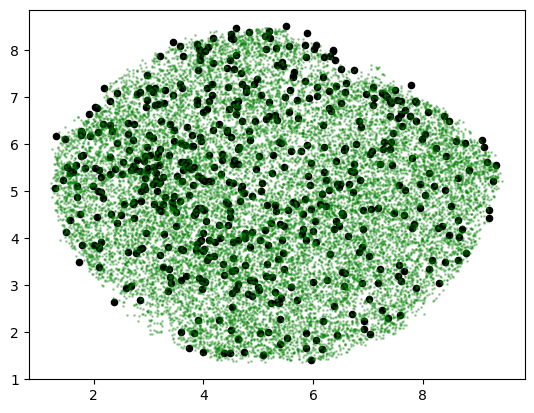

In [23]:
plt.scatter(third_embs[:,0], third_embs[:,1], c='black', s=20, alpha=1)
plt.scatter(visual_embs[:,0], visual_embs[:,1], c='g', s=1, alpha=0.3)

# Density map of HCP

In [24]:
Z, xedges, yedges = np.histogram2d(hcp_embs[:,0], hcp_embs[:,1], bins=15, normed=True)

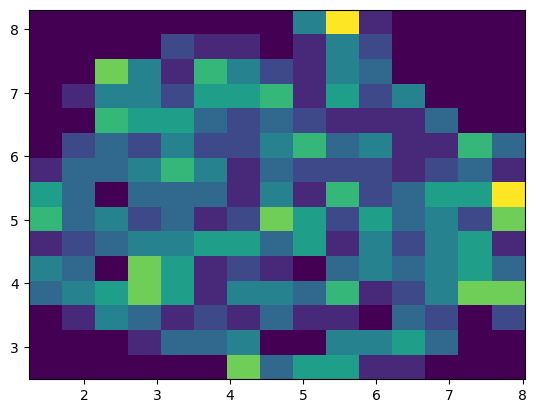

In [25]:
plt.pcolormesh(xedges, yedges, Z.T)

In [26]:
# fig, ax = plt.subplots(figsize=[15,8])
# plt.imshow(Z.T)

In [27]:
Z = Z/np.unique(Z)[1]

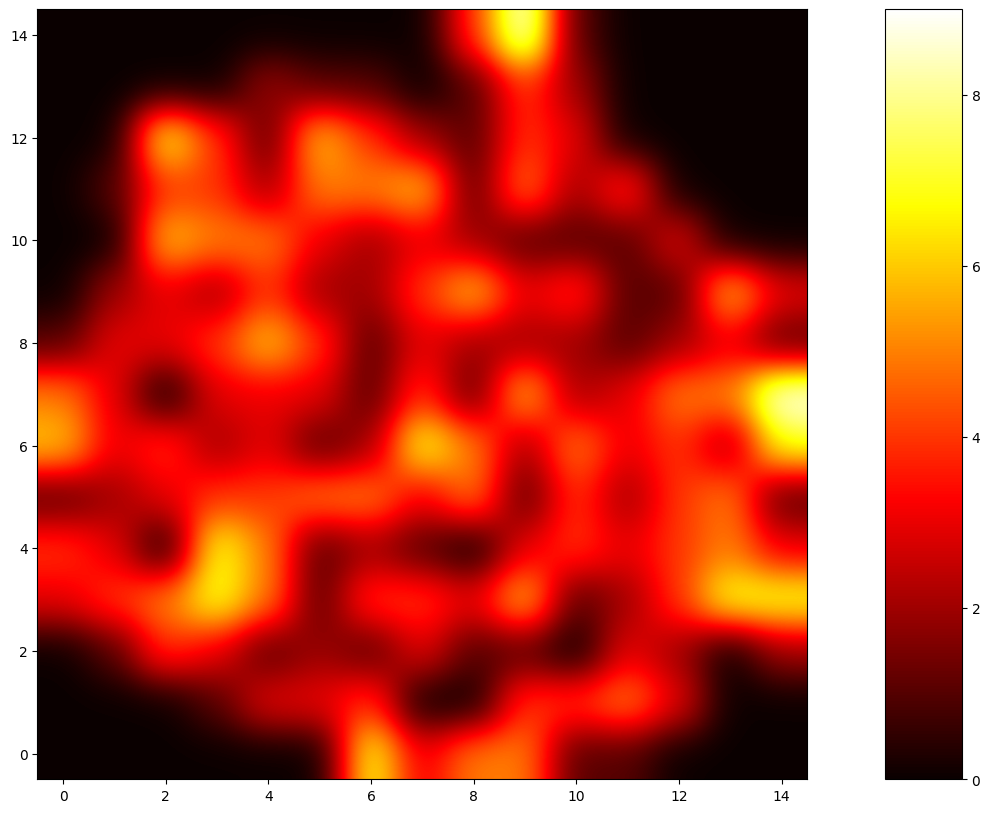

In [28]:
fig, ax = plt.subplots(figsize=[20,10])
cax = ax.imshow(Z.T,
          origin='lower',
          cmap='hot', 
          interpolation='gaussian'
          )
cbar   = fig.colorbar(cax,aspect=10)

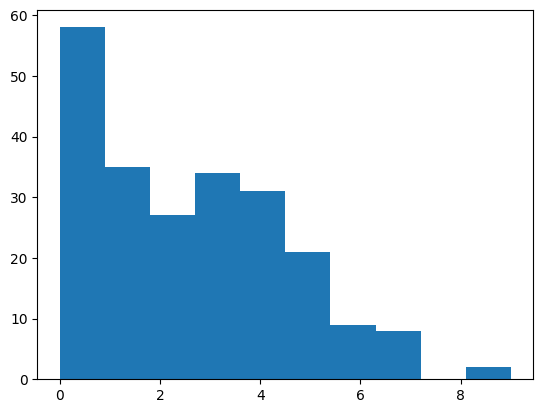

In [29]:
h = plt.hist(Z.reshape(Z.size,1), bins=10)

In [30]:
# import scipy.ndimage as ndi

In [31]:
# img = ndi.gaussian_filter(Z, (1,1))
# f, axs = plt.subplots(1, 1, figsize=(15, 15))
# plt.imshow(img)